In [1]:
import os, gc, random
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm
from time import time, ctime

from sklearn.model_selection import KFold, GroupKFold

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam, AdamW
from torch.cuda.amp import autocast, GradScaler

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy
from scipy.special import rel_entr

In [2]:
def get_logger(log_dir, logger_name="train_model.log"):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger_file = os.path.join(log_dir, logger_name)
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=logger_file, mode="a+")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
class ModelConfig:
    SEED = 20
    SPLIT_ENTROPY = 5.5
    MODEL_NAME = "EEGSeq_ResNet_GRU_Wavenet"
    MODEL_BACKBONE = "wavenet"
    BATCH_SIZE = 32
    EPOCHS = 30
    EARLY_STOP_ROUNDS = 5
    GRADIENT_ACCUMULATION_STEPS = 1
    DROP_RATE = 0.15 # default: 0.1
    DROP_PATH_RATE = 0.25 # default: 0.2
    WEIGHT_DECAY = 0.01
    AMP = True
    PRINT_FREQ = 100
    NUM_WORKERS = 0 
    MAX_GRAD_NORM = 1e7

In [4]:
N_GPU = torch.cuda.device_count()
if N_GPU > 1:
    DEVICE = torch.device("cuda")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
elif N_GPU == 1:
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")

print("Use Device: ", DEVICE)

Use Device:  cuda:0


In [5]:
class KagglePaths:
    OUTPUT_DIR = "/kaggle/working/"
    PRE_LOADED_EEGS = '/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTROGRAMS = '/kaggle/input/brain-spectrograms/specs.npy'
    TRAIN_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"
    TRAIN_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/"
    TEST_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"
    TEST_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/"
    TEST_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"


class LocalPaths:
    OUTPUT_DIR = "./outputs/"
    PRE_LOADED_EEGS = './inputs/brain-eeg-spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTROGRAMS = './inputs/brain-spectrograms/specs.npy'
    TRAIN_CSV = "./inputs/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "./inputs/hms-harmful-brain-activity-classification/train_eegs"
    TRAIN_SPECTROGRAMS = "./inputs/hms-harmful-brain-activity-classification/train_spectrograms"
    TEST_CSV = "./inputs/hms-harmful-brain-activity-classification/test.csv"
    TEST_SPECTROGRAMS = "./inputs/hms-harmful-brain-activity-classification/test_spectrograms"
    TEST_EEGS = "./inputs/hms-harmful-brain-activity-classification/test_eegs"

PATHS = KagglePaths if os.path.exists("/kaggle") else LocalPaths

print("Output Dir: ", PATHS.OUTPUT_DIR)

EEG_FEAT_ALL = [
    'Fp1', 'F3', 'C3', 'P3', 
    'F7', 'T3', 'T5', 'O1', 
    'Fz', 'Cz', 'Pz', 'Fp2', 
    'F4', 'C4', 'P4', 'F8', 
    'T4', 'T6', 'O2', 'EKG'
    ]

EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}

BRAIN_ACTIVITY = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
TARGETS = [f"{lb}_vote" for lb in BRAIN_ACTIVITY]
TARGETS_PRED = [f"{lb}_pred" for lb in BRAIN_ACTIVITY]

seed_everything(ModelConfig.SEED)

Output Dir:  ./outputs/


In [6]:
logger = get_logger(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_train.log")

# Load Data

In [7]:
def eeg_from_parquet(parquet_path: str, use_feature=EEG_FEAT_USE, display: bool = False) -> np.ndarray:
    # === Extract full length EEG Sequence ===
    # fill missing values with mean
    # first fill missing values with mean of each column
    # then if all values are missing, fill with 0
    eeg = pd.read_parquet(parquet_path, columns=use_feature)
    eeg = eeg.fillna(eeg.mean(skipna=True)).fillna(0)
    data = eeg.values.astype(np.float32)

    if display:
        fig, ax = plt.subplots(len(use_feature), 1, figsize=(10, 2*len(use_feature)), sharex=True)
        
        for i, feat in enumerate(use_feature):
            ax[i].plot(data[:, i], label=feat)
            ax[i].legend()
            ax[i].grid()
       
        name = parquet_path.split('/')[-1].split('.')[0]
        ax[0].set_title(f'EEG {name}',size=16)
        fig.tight_layout()
        plt.show()    
    return data

def get_non_overlap(train_csv, targets):

    df = train_csv.groupby(['eeg_id'] + targets).agg({
            'spectrogram_id': 'first',
            'spectrogram_label_offset_seconds': ['min', 'max'],
            'eeg_label_offset_seconds': ['min', 'max'],
            'patient_id': 'first',
            'expert_consensus': 'first',
            'total_votes': 'sum',
            'entropy': 'mean',
            'is_hard': 'mean'
        }).reset_index()

    df.columns = ["eeg_id"] + targets + \
        ['spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'patient_id', 'target', 'total_votes', 'average_entropy', 'is_hard']

    df[targets] = df[targets].apply(lambda x: x / x.sum(), axis=1)

    return df

  0%|          | 0/17300 [00:00<?, ?it/s]

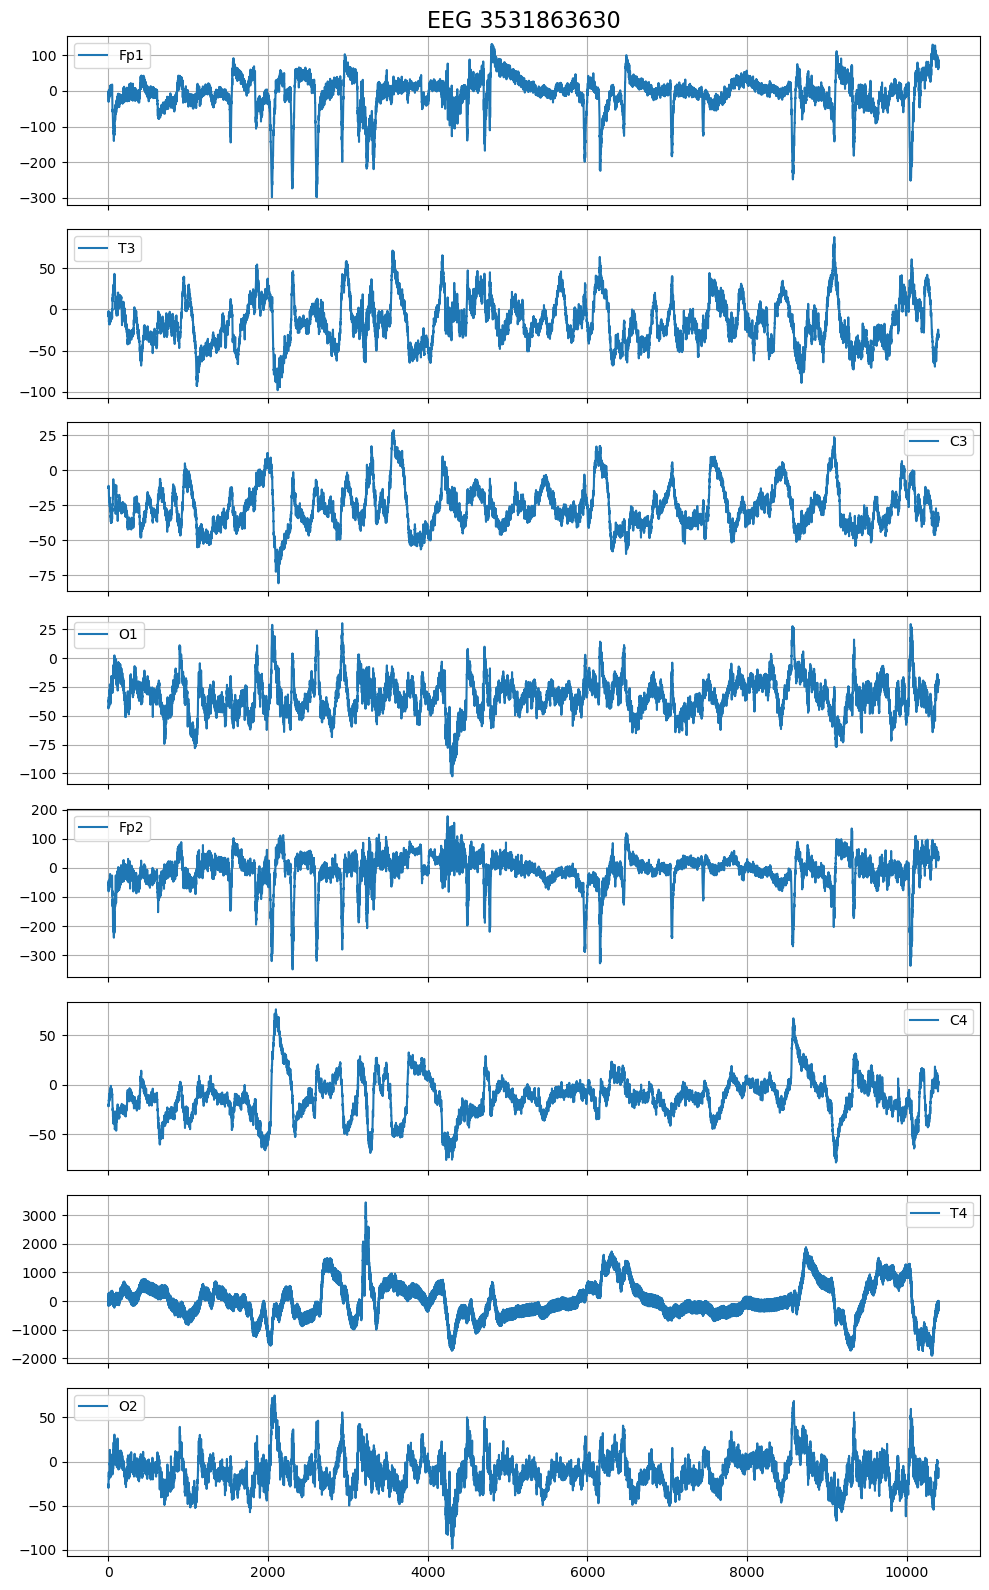

CPU times: user 1min 19s, sys: 7.54 s, total: 1min 27s
Wall time: 57.9 s


In [8]:
%%time
CREATE_EEGS = True
ALL_EEG_SIGNALS = {}
eeg_paths = list(Path(PATHS.TRAIN_EEGS).glob('*.parquet'))
preload_eegs_path = Path('./inputs/eegs_full.npy')

if CREATE_EEGS:
    count = 0
    for parquet_path in tqdm(eeg_paths, total=len(eeg_paths)):
        eeg_id = int(parquet_path.stem)
        eeg_path = str(parquet_path)
        data = eeg_from_parquet(eeg_path, display=count<1)
        ALL_EEG_SIGNALS[eeg_id] = data
        count += 1
#     np.save("./inputs/eegs_full.npy", ALL_EEG_SIGNALS)
else:
    ALL_EEG_SIGNALS = np.load(preload_eegs_path, allow_pickle=True).item()

In [9]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:].tolist()

print("targets: ", targets)

train_csv['total_votes'] = train_csv[targets].sum(axis=1)

targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)

train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: sum(rel_entr([1/6]*6, row.values+1e-5)), axis=1)
train_csv['is_hard'] = (train_csv['entropy'] < 5.5).astype(int)

train_all = get_non_overlap(train_csv, targets)
train_hard = get_non_overlap(train_csv[train_csv['is_hard'] == 1].copy().reset_index(), targets)

print("train_all: ", train_all.shape)
print("hard samples: ", train_hard.shape)

train_all.head(15)

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_all:  (20183, 17)
hard samples:  (4096, 17)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,eeg_off_min,eeg_off_max,patient_id,target,total_votes,average_entropy,is_hard
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,0.0,16.0,20654,Other,48,4.584192,1.0
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,0.0,38.0,20230,LPD,154,4.870032,1.0
2,642382,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,14960202,1008.0,1032.0,0.0,24.0,5955,Other,2,7.802343,0.0
3,751790,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,618728447,908.0,908.0,0.0,0.0,38549,GPD,1,7.802343,0.0
4,778705,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,52296320,0.0,0.0,0.0,0.0,40955,Other,2,7.802343,0.0
5,1629671,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2036345030,0.0,160.0,0.0,160.0,37481,Seizure,51,7.802343,0.0
6,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,0.0,0.0,47999,Other,13,4.847483,1.0
7,2061593,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,320962633,1450.0,1450.0,0.0,0.0,23828,Other,1,7.802343,0.0
8,2078097,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2074135650,3342.0,3342.0,0.0,0.0,61174,Other,2,7.802343,0.0
9,2366870,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,1232582129,0.0,30.0,0.0,30.0,23633,Other,18,6.134196,0.0


# Dataset

In [10]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y

def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x #quantized

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


In [11]:
class EEGSeqDataset(Dataset):
    def __init__(self, df, config, eegs, mode='train', verbose=False):
        self.df = df
        self.mode = mode
        self.eegs = eegs
        self.verbose = verbose
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        X, y_prob = self.__data_generation(idx)
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y_prob, dtype=torch.float32)
    
    def __data_generation(self, index):
        row = self.df.iloc[index]

        if self.verbose:
            print(f"Row {index}", row[['eeg_id', 'eeg_off_min', 'eeg_off_max', 'target']].tolist())

        X = np.zeros((10_000, 8), dtype='float32')
        
        start_sec = int((row['eeg_off_min'] + row['eeg_off_max']) // 2)
        data = self.eegs[row.eeg_id][start_sec*200 : (start_sec+50)*200]

        # === Feature engineering ===
        X[:,0] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['T3']]
        X[:,1] = data[:,EEF_FEAT_INDEX['T3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,2] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['C3']]
        X[:,3] = data[:,EEF_FEAT_INDEX['C3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,4] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['C4']]
        X[:,5] = data[:,EEF_FEAT_INDEX['C4']] - data[:,EEF_FEAT_INDEX['O2']]

        X[:,6] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['T4']]
        X[:,7] = data[:,EEF_FEAT_INDEX['T4']] - data[:,EEF_FEAT_INDEX['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        # !!! change to bandpass filter (low=0.5, hight=20, order=2) !!!
        # X = butter_lowpass_filter(X)
        X = butter_bandpass_filter(X, .5, 20, 200, order=2)

        if self.mode != 'test':
            y_prob = row[TARGETS].values.astype(np.float32)
        else:
            y_prob = np.zeros(6, dtype='float32')

        return X[::5, :], y_prob


In [12]:
# visualize the dataset

# train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
# train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

# for batch in train_loader:
#     X, y = batch
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
    
#     fig, axes = plt.subplots(4, 1, figsize=(20, 20))
#     for item in range(4):
#         offset = 0
#         for col in range(X.shape[-1]):
#             if col != 0:
#                 offset -= X[item,:,col].min()
#             axes[item].plot(np.arange(X.shape[1]), X[item,:,col]+offset, label=f'feature {col+1}')
#             offset += X[item,:,col].max()
#         tt = f'{y[col][0]:0.1f}'
#         for t in y[col][1:]:
#             tt += f', {t:0.1f}'
#         axes[item].set_title(f'Target = {tt}',size=14)
#         axes[item].legend()
#     fig.tight_layout()
#     plt.show()
#     break

In [13]:
# del train_dataset, train_loader
# torch.cuda.empty_cache()
# gc.collect()

# Model

### Sequencial GRU Encoder

In [14]:
class SeqGRUEncoder(nn.Module):
    def __init__(self, in_channels, hidden_size=128, num_layers=2, bidirectional=True):
        super(SeqGRUEncoder, self).__init__()

        self.in_channels = in_channels

        # Initialize the GRU to have 128 hidden units per direction and to be bidirectional
        self.rnn = nn.GRU(
            input_size=in_channels, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            bidirectional=bidirectional, 
            batch_first=True
        )
        
        # Initialize the attention mechanism
        if bidirectional:
            emb_dim = 2 * hidden_size
        else:
            emb_dim = hidden_size
        
        self.attention_dense = nn.Linear(emb_dim, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        rnn_out, _ = self.rnn(x)  # -> [batch, seq_len, emb_dim]
        identity = rnn_out
        scores = self.attention_dense(rnn_out).squeeze(-1)
        scores = self.softmax(scores).unsqueeze(1)
        pooled_out = torch.matmul(scores, identity).squeeze(1)
        # -> [batch_size, emb_dim]
        return pooled_out

### Resnet 1D Encoder

In [15]:
class ResNet_1D_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling, dropout=0.0):
        super(ResNet_1D_Block, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(num_features=in_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm1d(num_features=out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        )
        self.downsampling = downsampling
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        identity = self.downsampling(x)
        out = self.block(x)
        out += identity
        return out
    
    
class ResNet_1D_Encoder(nn.Module):
    def __init__(self, kernels=[3,7,9,11], planes=24, in_channels=8, fixed_kernel_size=5, n_blocks=9, dropout=0.0):
        super(ResNet_1D_Encoder, self).__init__()

        self.parallel_conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=planes, 
                kernel_size=kernel_size,
                stride=1, 
                padding=0, 
                bias=False
            ) for kernel_size in kernels
        ])

        self.resnet_layer = ResNet_1D_Block(
            in_channels=planes, 
            out_channels=planes, 
            kernel_size=fixed_kernel_size,
            stride=1, 
            padding=fixed_kernel_size//2, 
            downsampling=nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
            dropout=dropout
        )
        
        self.resnet_part = nn.Sequential(
            nn.BatchNorm1d(num_features=planes),
            nn.ReLU(inplace=False),
            nn.Conv1d(
                in_channels=planes, 
                out_channels=planes, 
                kernel_size=fixed_kernel_size, 
                stride=2, 
                padding=2, 
                bias=False
            ),
            *[
                ResNet_1D_Block(
                    in_channels=planes,
                    out_channels=planes,
                    kernel_size=fixed_kernel_size,
                    stride=1,
                    padding=fixed_kernel_size//2,
                    downsampling=nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                    dropout=dropout
                    ) 
                for _ in range(n_blocks)
            ],
            nn.BatchNorm1d(num_features=planes),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
        )

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        # print("Resnet Input Shape: ", x.shape)
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
       
        out_sep = [conv(x) for conv in self.parallel_conv]
        out = torch.cat(out_sep, dim=2)
        out = self.resnet_part(out)
        
        # Return the flattened features from the last convolutional layer
        features = out.reshape(out.shape[0], -1)
        return features


### DilatedInception Wavenet Encoder

In [16]:
from typing import List

class DilatedInception(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_sizes: List[int], dilation: int) -> None:
        super().__init__()
        assert out_channels % len(kernel_sizes) == 0, "`out_channels` must be divisible by the number of kernel sizes."
        hidden_dim = out_channels // len(kernel_sizes)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels, hidden_dim, k, padding='same', dilation=dilation)
            for k in kernel_sizes
        ])

    def forward(self, x):
        outputs = [conv(x) for conv in self.convs]
        out = torch.cat(outputs, dim=1)
        return out

class GatedTCN(nn.Module):
    def __init__(self, in_dim: int, h_dim: int, kernel_sizes: List[int], dilation_factor: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.filt = DilatedInception(in_dim, h_dim, kernel_sizes, dilation=dilation_factor)
        self.gate = DilatedInception(in_dim, h_dim, kernel_sizes, dilation=dilation_factor)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x_filt = torch.tanh(self.filt(x))
        x_gate = torch.sigmoid(self.gate(x))
        h = x_filt * x_gate
        h = self.dropout(h)
        return h

class WaveBlock(nn.Module):
    def __init__(self, n_layers: int, in_dim: int, h_dim: int, kernel_sizes: List[int]) -> None:
        super().__init__()
        self.dilation_rates = [2**i for i in range(n_layers)]
        self.in_conv = nn.Conv1d(in_dim, h_dim, kernel_size=1)
        self.gated_tcns = nn.ModuleList([
            GatedTCN(h_dim, h_dim, kernel_sizes, dilation)
            for dilation in self.dilation_rates
        ])
        self.skip_convs = nn.ModuleList([
            nn.Conv1d(h_dim, h_dim, kernel_size=1)
            for _ in range(n_layers)
            ])
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.in_conv.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.in_conv.bias)
        for conv in self.skip_convs:
            nn.init.xavier_uniform_(conv.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(conv.bias)

    def forward(self, x):
        # x: (B, C, L)
        x = self.in_conv(x)
        x_skip = x
        for gated_tcn, skip_conv in zip(self.gated_tcns, self.skip_convs):
            x = gated_tcn(x)
            x = skip_conv(x)
            x_skip = x_skip + x
        return x_skip

class DilatedWaveNet(nn.Module):
    """WaveNet architecture with dilated inception conv, enhanced with list comprehension for input processing."""

    def __init__(self, kernel_sizes: List[int]) -> None:
        super().__init__()
        self.kernel_sizes = kernel_sizes
        
        # Initialize wave blocks with specified kernel sizes
        self.wave_module = nn.Sequential(
            WaveBlock(9, 8, 128, self.kernel_sizes), #12
            WaveBlock(6, 128, 256, self.kernel_sizes), #8
            WaveBlock(3, 256, 512, self.kernel_sizes), #4
            WaveBlock(1, 512, 512, self.kernel_sizes), #1
        )
        self.pool_layer = nn.AdaptiveAvgPool1d(1)

    def forward(self, x) -> torch.Tensor:
        # x: (B, L, C)
        bs, seq_len, n_channels = x.shape
        x = x.permute(0, 2, 1) # -> (B, C, L)
        # Process different parts of the input with list comprehension
        x = self.wave_module(x)
        x = self.pool_layer(x) # ->(B, 512, 1)
        x = x.reshape(bs, n_channels, -1).reshape(bs, n_channels//2, 2, 64)
        features = x.mean(dim=2).reshape(bs, -1) # -> (16, 256)
#         pooled_outputs = [(x[:, i:i+64] + x[:, i+64:i+128]) / 2 for i in range(0, n_channels, 2)]
#         # Combine the pooled features and reshape for classification
#         features = torch.cat(pooled_outputs, dim=1).reshape(bs, -1)
       
        return features

### EEGSeqClassifier 

In [17]:
class EEGSeqClassifier(nn.Module):
    def __init__(self, config, num_classes=6):
        super(EEGSeqClassifier, self).__init__()

        # downsample layer (by a factor of 2)
        # self.ds_layer = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=2, padding=1)
#         self.ds_layer = nn.AvgPool1d(kernel_size5, stride=5, padding=0)
        
        self.seqgru = SeqGRUEncoder(in_channels=8, hidden_size=128, num_layers=2, bidirectional=True)
        self.resnet = ResNet_1D_Encoder(
            kernels=[3, 5, 7, 9, 11], 
            planes=24, 
            in_channels=8, 
            fixed_kernel_size=5, 
            n_blocks=8, 
            dropout=0.0
        )
        self.wavenet = DilatedWaveNet(kernel_sizes=[2, 3, 6, 7])

        hidden_dim = 72 + 256 + 256

        self.predict_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        # x = self.ds_layer(x.permute(0, 2, 1)) # ->(batch, channels, seq_len)
        # x = x.permute(0, 2, 1)
        resnet_out = self.resnet(x)
        seqgru_out = self.seqgru(x)
        wavenet_out = self.wavenet(x)

        features = torch.cat([seqgru_out, resnet_out, wavenet_out], dim=1)

        logits = self.predict_head(features)
        return logits

In [18]:
# train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
# train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

# model = EEGSeqClassifier(ModelConfig, num_classes=6)
# model.to(DEVICE)
# for i, batch in enumerate(train_loader):
#     X, y = batch
#     X = X.to(DEVICE)
#     y = y.to(DEVICE)
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
    
#     y_pred = model(X)
#     print(y_pred.shape)
#     break 

# del model, train_dataset, train_loader, X, y
# torch.cuda.empty_cache()
# gc.collect()

In [19]:
!nvidia-smi

Sun Mar 31 23:14:01 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 36%   38C    P8     5W / 260W |     15MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Train

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class Trainer:

    def __init__(self, model, config, logger):

        self.model = model
        self.logger = logger
        self.config = config
        
        self.early_stop_rounds = config.EARLY_STOP_ROUNDS
        self.early_stop_counter = 0
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.criterion = nn.KLDivLoss(reduction="batchmean")

    def train(self, train_loader, valid_loader, from_checkpoint=None):

        self.optimizer = AdamW(self.model.parameters(), lr=1e-3, weight_decay=self.config.WEIGHT_DECAY)

        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=1e-4,
            epochs=self.config.EPOCHS,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
            final_div_factor=100,
        )

        if from_checkpoint is not None:
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("inf")
        loss_records = {"train": [], "valid": []}

        for epoch in range(self.config.EPOCHS):
            start_epoch = time()

            train_loss, _ = self._train_or_valid_epoch(epoch, train_loader, is_train=True)
            valid_loss, valid_preds = self._train_or_valid_epoch(epoch, valid_loader, is_train=False)

            loss_records["train"].append(train_loss)
            loss_records["valid"].append(valid_loss)

            elapsed = time() - start_epoch

            info = f"{'-' * 100}\nEpoch {epoch + 1} - "
            info += f"Average Loss: (train) {train_loss:.4f}; (valid) {valid_loss:.4f} | Time: {elapsed:.2f}s"
            self.logger.info(info)

            if valid_loss < best_loss:
                best_loss = valid_loss
                best_weights = self.model.state_dict()
                best_preds = valid_preds
                self.logger.info(f"Best model found in epoch {epoch + 1} | valid loss: {best_loss:.4f}")
                self.early_stop_counter = 0
            
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.early_stop_rounds:
                    self.logger.info(f"Early stopping at epoch {epoch + 1}")
                    break

        return best_weights, best_preds, loss_records

    def _train_or_valid_epoch(self, epoch_id, dataloader, is_train=True):

        self.model.train() if is_train else self.model.eval()
        mode = "Train" if is_train else "Valid"

        len_loader = len(dataloader)
        scaler = GradScaler(enabled=self.config.AMP)
        loss_meter, predicts_record = AverageMeter(), []

        start = time()
        pbar = tqdm(dataloader, total=len(dataloader), unit="batch", desc=f"{mode} [{epoch_id}]")
        for step, (X, y) in enumerate(pbar):
            X, y = X.to(self.device), y.to(self.device)

            if is_train:
                with autocast(enabled=self.config.AMP):
                    y_pred = self.model(X)
                    loss = self.criterion(F.log_softmax(y_pred, dim=1), y)
                if self.config.GRADIENT_ACCUMULATION_STEPS > 1:
                    loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.MAX_GRAD_NORM)
                if (step + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
            else:
                with torch.no_grad():
                    y_pred = self.model(X)
                    loss = self.criterion(F.log_softmax(y_pred, dim=1), y)
                if self.config.GRADIENT_ACCUMULATION_STEPS > 1:
                    loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                
                predicts_record.append(y_pred.to('cpu').numpy())
            
            loss_meter.update(loss.item(), y.size(0))
            end = time()

            if (step % self.config.PRINT_FREQ == 0) or (step == (len_loader - 1)):
                lr = self.scheduler.get_last_lr()[0]
                info = f"Epoch {epoch_id + 1} [{step}/{len_loader}] | {mode} Loss: {loss_meter.avg:.4f}"
                if is_train:
                    info += f" Grad: {grad_norm:.4f} LR: {lr:.4e}"
                info += f" | Elapse: {end - start:.2f}s"
                print(info)

        if not is_train:
            predicts_record = np.concatenate(predicts_record)
            
        return loss_meter.avg, predicts_record


In [22]:
def prepare_k_fold(df, k_folds=5):

    kf = KFold(n_splits=k_folds)
    unique_spec_id = df['spectrogram_id'].unique()
    df['fold'] = k_folds

    for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
        df.loc[df['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

    return df


def train_fold(model, fold_id, train_folds, valid_folds, logger, stage=1, checkpoint=None):

    train_dataset = EEGSeqDataset(train_folds, ModelConfig, ALL_EEG_SIGNALS, mode="train")
    valid_dataset = EEGSeqDataset(valid_folds, ModelConfig, ALL_EEG_SIGNALS, mode="valid")

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }

    train_loader = DataLoader(train_dataset, drop_last=True, collate_fn=None, **loader_kwargs)
    valid_loader = DataLoader(valid_dataset, drop_last=False, collate_fn=None, **loader_kwargs)

    trainer = Trainer(model, ModelConfig, logger)
    best_weights, best_preds, loss_records = trainer.train(
        train_loader, valid_loader, from_checkpoint=checkpoint)

    save_model_name = f"{ModelConfig.MODEL_NAME}_fold_{fold_id}_stage_{stage}.pth"
    torch.save(best_weights, os.path.join(PATHS.OUTPUT_DIR, save_model_name))

    del train_dataset, valid_dataset, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

In [23]:
def evaluate_oof(oof_df):
    '''
    Evaluate the out-of-fold dataframe using KL Divergence (torch and kaggle)
    '''
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[TARGETS].values.astype('float32'))
    preds = F.log_softmax(
        torch.tensor(oof_df[TARGETS_PRED].values.astype('float32'), requires_grad=False),
        dim=1
    )
    kl_torch = kl_loss(preds, labels).item()

    return kl_torch

In [24]:
# gkf = GroupKFold(n_splits=k_folds)
# for fold, (train_index, valid_index) in enumerate(gkf.split(train_all, train_all.target, train_all.patient_id)):
#     train_all.loc[valid_index, "fold"] = int(fold)

# for fold in range(k_folds):
#     print(f"Fold {fold} = {len(train_all[train_all['fold'] == fold])}")

In [25]:
# Major Train Loop
# ================== Logger ==================
logger.info(f"{'*' * 100}")
logger.info(f"Script Start: {ctime()}")
logger.info(f"Model Configurations:")
for key, value in ModelConfig.__dict__.items():
    if not key.startswith("__"):
        logger.info(f"{key}: {value}")
logger.info(f"{'*' * 100}")

# ================== Prepare Training ==================
oof_stage_1 = pd.DataFrame()
loss_history_1 = []
k_folds = 5
train_all = prepare_k_fold(train_all, k_folds=k_folds)
tik_total = time()

# ================== Stage 1: Train ====================
logger.info(f"{'=' * 100}\nStage 1: Train ResNetGRU\n{'=' * 100}")
for fold in range(k_folds):
    tik = time()

    ModelConfig.RESNET_GRU_DROPOUT = 0.0

    # model = ResNetGRU( ModelConfig, num_classes=6 )
    model = EEGSeqClassifier(ModelConfig, num_classes=6)
    
    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)
    train_folds = train_all[train_all['fold'] != fold].reset_index(drop=True)

    ## STAGE 1
    logger.info(f"{'=' * 100}\nFold: {fold} || Valid: {valid_folds.shape[0]}; \n{'=' * 100}")
    logger.info(f"- Train: {train_folds.shape[0]}; Epoch = {ModelConfig.EPOCHS}; Dropout = {ModelConfig.RESNET_GRU_DROPOUT} -")
    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=1, checkpoint=None)

    loss_history_1.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_1 = pd.concat([oof_stage_1, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_1.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_1.csv"), index=False)

info = f"{'=' * 100}\nStage 1 Training Complete!\n"
cv_results = evaluate_oof(oof_stage_1)
info += f"CV Result (Stage 1): {cv_results}\n"
info += f"Elapse: {(time() - tik_total) / 60:.2f} min \n{'=' * 100}"
logger.info(info)


****************************************************************************************************
Script Start: Sun Mar 31 23:14:02 2024
Model Configurations:
SEED: 20
SPLIT_ENTROPY: 5.5
MODEL_NAME: EEGSeq_ResNet_GRU_Wavenet
MODEL_BACKBONE: wavenet
BATCH_SIZE: 32
EPOCHS: 30
EARLY_STOP_ROUNDS: 5
GRADIENT_ACCUMULATION_STEPS: 1
DROP_RATE: 0.15
DROP_PATH_RATE: 0.25
WEIGHT_DECAY: 0.01
AMP: True
PRINT_FREQ: 100
NUM_WORKERS: 0
MAX_GRAD_NORM: 10000000.0
****************************************************************************************************
Stage 1: Train ResNetGRU
Fold: 0 || Valid: 7314; 
- Train: 12869; Epoch = 30; Dropout = 0.0 -


Train [0]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 1 [0/402] | Train Loss: 1.5303 Grad: 181816.9531 LR: 4.0002e-06 | Elapse: 1.15s
Epoch 1 [100/402] | Train Loss: 1.3329 Grad: 104470.9609 LR: 5.6545e-06 | Elapse: 43.77s
Epoch 1 [200/402] | Train Loss: 1.2886 Grad: 207819.4375 LR: 1.0441e-05 | Elapse: 86.80s
Epoch 1 [300/402] | Train Loss: 1.2636 Grad: 99649.9375 LR: 1.8037e-05 | Elapse: 130.20s
Epoch 1 [400/402] | Train Loss: 1.2443 Grad: 193904.1094 LR: 2.7928e-05 | Elapse: 173.86s
Epoch 1 [401/402] | Train Loss: 1.2440 Grad: 122670.3906 LR: 2.8036e-05 | Elapse: 174.29s


Valid [0]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 1 [0/229] | Valid Loss: 1.1556 | Elapse: 0.33s
Epoch 1 [100/229] | Valid Loss: 1.2127 | Elapse: 31.76s
Epoch 1 [200/229] | Valid Loss: 1.2467 | Elapse: 63.20s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.2440; (valid) 1.2481 | Time: 246.19s
Best model found in epoch 1 | valid loss: 1.2481


Epoch 1 [228/229] | Valid Loss: 1.2481 | Elapse: 71.90s


Train [1]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 2 [0/402] | Train Loss: 1.5154 Grad: 261513.2656 LR: 2.8145e-05 | Elapse: 0.44s
Epoch 2 [100/402] | Train Loss: 1.1879 Grad: 121989.6562 LR: 3.9688e-05 | Elapse: 44.08s
Epoch 2 [200/402] | Train Loss: 1.1530 Grad: 210143.0469 LR: 5.2063e-05 | Elapse: 87.79s
Epoch 2 [300/402] | Train Loss: 1.1240 Grad: 110119.7891 LR: 6.4433e-05 | Elapse: 131.51s
Epoch 2 [400/402] | Train Loss: 1.1056 Grad: 230277.3125 LR: 7.5964e-05 | Elapse: 175.32s
Epoch 2 [401/402] | Train Loss: 1.1052 Grad: 130658.8516 LR: 7.6072e-05 | Elapse: 175.77s


Valid [1]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 2 [0/229] | Valid Loss: 0.9625 | Elapse: 0.32s
Epoch 2 [100/229] | Valid Loss: 1.0226 | Elapse: 31.94s
Epoch 2 [200/229] | Valid Loss: 1.0570 | Elapse: 63.56s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.1052; (valid) 1.0601 | Time: 248.06s
Best model found in epoch 2 | valid loss: 1.0601


Epoch 2 [228/229] | Valid Loss: 1.0601 | Elapse: 72.29s


Train [2]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 3 [0/402] | Train Loss: 1.0714 Grad: 184813.3281 LR: 7.6180e-05 | Elapse: 0.44s
Epoch 3 [100/402] | Train Loss: 1.0433 Grad: 128991.3906 LR: 8.6052e-05 | Elapse: 44.27s
Epoch 3 [200/402] | Train Loss: 1.0117 Grad: 131137.5000 LR: 9.3621e-05 | Elapse: 88.07s
Epoch 3 [300/402] | Train Loss: 0.9905 Grad: 91076.6797 LR: 9.8378e-05 | Elapse: 131.90s
Epoch 3 [400/402] | Train Loss: 0.9722 Grad: 262234.6875 LR: 1.0000e-04 | Elapse: 175.73s
Epoch 3 [401/402] | Train Loss: 0.9718 Grad: 139879.6094 LR: 1.0000e-04 | Elapse: 176.16s


Valid [2]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 3 [0/229] | Valid Loss: 0.8535 | Elapse: 0.32s
Epoch 3 [100/229] | Valid Loss: 0.8989 | Elapse: 32.00s
Epoch 3 [200/229] | Valid Loss: 0.9425 | Elapse: 63.66s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.9718; (valid) 0.9450 | Time: 248.56s
Best model found in epoch 3 | valid loss: 0.9450


Epoch 3 [228/229] | Valid Loss: 0.9450 | Elapse: 72.40s


Train [3]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 4 [0/402] | Train Loss: 0.8506 Grad: 165306.1406 LR: 1.0000e-04 | Elapse: 0.44s
Epoch 4 [100/402] | Train Loss: 0.9058 Grad: 163509.8281 LR: 9.9978e-05 | Elapse: 44.28s
Epoch 4 [200/402] | Train Loss: 0.8853 Grad: 116972.5391 LR: 9.9915e-05 | Elapse: 88.10s
Epoch 4 [300/402] | Train Loss: 0.8785 Grad: 101895.4531 LR: 9.9809e-05 | Elapse: 131.93s
Epoch 4 [400/402] | Train Loss: 0.8701 Grad: 235571.7031 LR: 9.9662e-05 | Elapse: 175.76s
Epoch 4 [401/402] | Train Loss: 0.8699 Grad: 149969.8281 LR: 9.9660e-05 | Elapse: 176.19s


Valid [3]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 4 [0/229] | Valid Loss: 0.8293 | Elapse: 0.32s
Epoch 4 [100/229] | Valid Loss: 0.8399 | Elapse: 32.00s
Epoch 4 [200/229] | Valid Loss: 0.8721 | Elapse: 63.68s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.8699; (valid) 0.8731 | Time: 248.62s
Best model found in epoch 4 | valid loss: 0.8731


Epoch 4 [228/229] | Valid Loss: 0.8731 | Elapse: 72.42s


Train [4]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 5 [0/402] | Train Loss: 0.7617 Grad: 131862.3906 LR: 9.9659e-05 | Elapse: 0.44s
Epoch 5 [100/402] | Train Loss: 0.8387 Grad: 155348.6406 LR: 9.9469e-05 | Elapse: 44.28s
Epoch 5 [200/402] | Train Loss: 0.8306 Grad: 113925.4844 LR: 9.9238e-05 | Elapse: 88.11s
Epoch 5 [300/402] | Train Loss: 0.8291 Grad: 96682.9219 LR: 9.8966e-05 | Elapse: 131.94s
Epoch 5 [400/402] | Train Loss: 0.8233 Grad: 194015.9062 LR: 9.8653e-05 | Elapse: 175.76s
Epoch 5 [401/402] | Train Loss: 0.8232 Grad: 144575.6094 LR: 9.8649e-05 | Elapse: 176.20s


Valid [4]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 5 [0/229] | Valid Loss: 0.8321 | Elapse: 0.32s
Epoch 5 [100/229] | Valid Loss: 0.8094 | Elapse: 31.97s
Epoch 5 [200/229] | Valid Loss: 0.8324 | Elapse: 63.59s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.8232; (valid) 0.8325 | Time: 248.53s
Best model found in epoch 5 | valid loss: 0.8325


Epoch 5 [228/229] | Valid Loss: 0.8325 | Elapse: 72.32s


Train [5]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 6 [0/402] | Train Loss: 0.7266 Grad: 129943.8203 LR: 9.8646e-05 | Elapse: 0.44s
Epoch 6 [100/402] | Train Loss: 0.7984 Grad: 135177.4062 LR: 9.8291e-05 | Elapse: 44.26s
Epoch 6 [200/402] | Train Loss: 0.7947 Grad: 114043.6797 LR: 9.7896e-05 | Elapse: 88.09s
Epoch 6 [300/402] | Train Loss: 0.7949 Grad: 98718.0312 LR: 9.7461e-05 | Elapse: 131.98s
Epoch 6 [400/402] | Train Loss: 0.7904 Grad: 163937.4375 LR: 9.6986e-05 | Elapse: 175.82s
Epoch 6 [401/402] | Train Loss: 0.7904 Grad: 147667.3125 LR: 9.6981e-05 | Elapse: 176.26s


Valid [5]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 6 [0/229] | Valid Loss: 0.8270 | Elapse: 0.32s
Epoch 6 [100/229] | Valid Loss: 0.7902 | Elapse: 31.99s
Epoch 6 [200/229] | Valid Loss: 0.8085 | Elapse: 63.56s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.7904; (valid) 0.8077 | Time: 248.56s
Best model found in epoch 6 | valid loss: 0.8077


Epoch 6 [228/229] | Valid Loss: 0.8077 | Elapse: 72.30s


Train [6]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 7 [0/402] | Train Loss: 0.7084 Grad: 131461.1406 LR: 9.6976e-05 | Elapse: 0.45s
Epoch 7 [100/402] | Train Loss: 0.7629 Grad: 130125.4688 LR: 9.6461e-05 | Elapse: 44.29s
Epoch 7 [200/402] | Train Loss: 0.7633 Grad: 109869.7500 LR: 9.5907e-05 | Elapse: 88.14s
Epoch 7 [300/402] | Train Loss: 0.7634 Grad: 110307.2266 LR: 9.5314e-05 | Elapse: 131.99s
Epoch 7 [400/402] | Train Loss: 0.7599 Grad: 155691.9531 LR: 9.4684e-05 | Elapse: 175.84s
Epoch 7 [401/402] | Train Loss: 0.7600 Grad: 147236.4219 LR: 9.4677e-05 | Elapse: 176.28s


Valid [6]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 7 [0/229] | Valid Loss: 0.8265 | Elapse: 0.32s
Epoch 7 [100/229] | Valid Loss: 0.7675 | Elapse: 32.02s
Epoch 7 [200/229] | Valid Loss: 0.7793 | Elapse: 63.73s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.7600; (valid) 0.7790 | Time: 248.76s
Best model found in epoch 7 | valid loss: 0.7790


Epoch 7 [228/229] | Valid Loss: 0.7790 | Elapse: 72.48s


Train [7]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 8 [0/402] | Train Loss: 0.6822 Grad: 143090.3438 LR: 9.4671e-05 | Elapse: 0.44s
Epoch 8 [100/402] | Train Loss: 0.7321 Grad: 125857.3047 LR: 9.4002e-05 | Elapse: 44.31s
Epoch 8 [200/402] | Train Loss: 0.7306 Grad: 118161.7031 LR: 9.3297e-05 | Elapse: 88.17s
Epoch 8 [300/402] | Train Loss: 0.7299 Grad: 129158.2656 LR: 9.2555e-05 | Elapse: 132.05s
Epoch 8 [400/402] | Train Loss: 0.7273 Grad: 159416.5469 LR: 9.1778e-05 | Elapse: 175.92s
Epoch 8 [401/402] | Train Loss: 0.7274 Grad: 149821.4844 LR: 9.1770e-05 | Elapse: 176.36s


Valid [7]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 8 [0/229] | Valid Loss: 0.8331 | Elapse: 0.32s
Epoch 8 [100/229] | Valid Loss: 0.7421 | Elapse: 32.02s
Epoch 8 [200/229] | Valid Loss: 0.7452 | Elapse: 63.74s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.7274; (valid) 0.7448 | Time: 248.86s
Best model found in epoch 8 | valid loss: 0.7448


Epoch 8 [228/229] | Valid Loss: 0.7448 | Elapse: 72.49s


Train [8]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 9 [0/402] | Train Loss: 0.6692 Grad: 162385.2344 LR: 9.1762e-05 | Elapse: 0.44s
Epoch 9 [100/402] | Train Loss: 0.6944 Grad: 131672.4531 LR: 9.0949e-05 | Elapse: 44.29s
Epoch 9 [200/402] | Train Loss: 0.6923 Grad: 120709.4453 LR: 9.0101e-05 | Elapse: 88.09s
Epoch 9 [300/402] | Train Loss: 0.6930 Grad: 145533.0000 LR: 8.9221e-05 | Elapse: 131.79s
Epoch 9 [400/402] | Train Loss: 0.6919 Grad: 158018.0938 LR: 8.8307e-05 | Elapse: 175.48s
Epoch 9 [401/402] | Train Loss: 0.6919 Grad: 149966.6406 LR: 8.8298e-05 | Elapse: 175.91s


Valid [8]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 9 [0/229] | Valid Loss: 0.8153 | Elapse: 0.32s
Epoch 9 [100/229] | Valid Loss: 0.7331 | Elapse: 31.84s
Epoch 9 [200/229] | Valid Loss: 0.7332 | Elapse: 63.41s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6919; (valid) 0.7330 | Time: 248.08s
Best model found in epoch 9 | valid loss: 0.7330


Epoch 9 [228/229] | Valid Loss: 0.7330 | Elapse: 72.16s


Train [9]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 10 [0/402] | Train Loss: 0.6697 Grad: 196916.4531 LR: 8.8288e-05 | Elapse: 0.45s
Epoch 10 [100/402] | Train Loss: 0.6597 Grad: 112079.8125 LR: 8.7342e-05 | Elapse: 44.29s
Epoch 10 [200/402] | Train Loss: 0.6596 Grad: 127775.4688 LR: 8.6364e-05 | Elapse: 88.14s
Epoch 10 [300/402] | Train Loss: 0.6594 Grad: 149910.3906 LR: 8.5356e-05 | Elapse: 132.00s
Epoch 10 [400/402] | Train Loss: 0.6587 Grad: 156995.0469 LR: 8.4318e-05 | Elapse: 175.86s
Epoch 10 [401/402] | Train Loss: 0.6586 Grad: 158991.0938 LR: 8.4308e-05 | Elapse: 176.30s


Valid [9]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 10 [0/229] | Valid Loss: 0.8134 | Elapse: 0.32s
Epoch 10 [100/229] | Valid Loss: 0.7189 | Elapse: 32.00s
Epoch 10 [200/229] | Valid Loss: 0.7162 | Elapse: 63.69s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6586; (valid) 0.7163 | Time: 248.74s
Best model found in epoch 10 | valid loss: 0.7163


Epoch 10 [228/229] | Valid Loss: 0.7163 | Elapse: 72.44s


Train [10]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 11 [0/402] | Train Loss: 0.6235 Grad: 196122.2188 LR: 8.4297e-05 | Elapse: 0.44s
Epoch 11 [100/402] | Train Loss: 0.6278 Grad: 113186.0078 LR: 8.3230e-05 | Elapse: 44.35s
Epoch 11 [200/402] | Train Loss: 0.6262 Grad: 121350.4297 LR: 8.2135e-05 | Elapse: 88.20s
Epoch 11 [300/402] | Train Loss: 0.6267 Grad: 147308.6719 LR: 8.1014e-05 | Elapse: 132.06s
Epoch 11 [400/402] | Train Loss: 0.6259 Grad: 159845.0156 LR: 7.9866e-05 | Elapse: 175.91s
Epoch 11 [401/402] | Train Loss: 0.6260 Grad: 169340.6875 LR: 7.9854e-05 | Elapse: 176.35s


Valid [10]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 11 [0/229] | Valid Loss: 0.8015 | Elapse: 0.32s
Epoch 11 [100/229] | Valid Loss: 0.7106 | Elapse: 32.01s
Epoch 11 [200/229] | Valid Loss: 0.7076 | Elapse: 63.67s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.6260; (valid) 0.7079 | Time: 248.76s
Best model found in epoch 11 | valid loss: 0.7079


Epoch 11 [228/229] | Valid Loss: 0.7079 | Elapse: 72.41s


Train [11]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 12 [0/402] | Train Loss: 0.5749 Grad: 199136.6875 LR: 7.9843e-05 | Elapse: 0.44s
Epoch 12 [100/402] | Train Loss: 0.5945 Grad: 118657.7969 LR: 7.8670e-05 | Elapse: 44.30s
Epoch 12 [200/402] | Train Loss: 0.5938 Grad: 134650.6094 LR: 7.7472e-05 | Elapse: 88.14s
Epoch 12 [300/402] | Train Loss: 0.5943 Grad: 150583.0625 LR: 7.6252e-05 | Elapse: 131.99s
Epoch 12 [400/402] | Train Loss: 0.5933 Grad: 180670.5156 LR: 7.5010e-05 | Elapse: 175.83s
Epoch 12 [401/402] | Train Loss: 0.5934 Grad: 202852.3438 LR: 7.4997e-05 | Elapse: 176.27s


Valid [11]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 12 [0/229] | Valid Loss: 0.7943 | Elapse: 0.32s
Epoch 12 [100/229] | Valid Loss: 0.7039 | Elapse: 31.99s
Epoch 12 [200/229] | Valid Loss: 0.7007 | Elapse: 63.66s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.5934; (valid) 0.7013 | Time: 248.67s
Best model found in epoch 12 | valid loss: 0.7013


Epoch 12 [228/229] | Valid Loss: 0.7013 | Elapse: 72.40s


Train [12]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 13 [0/402] | Train Loss: 0.5278 Grad: 201891.4219 LR: 7.4985e-05 | Elapse: 0.44s
Epoch 13 [100/402] | Train Loss: 0.5598 Grad: 126186.8203 LR: 7.3721e-05 | Elapse: 44.26s
Epoch 13 [200/402] | Train Loss: 0.5615 Grad: 132212.8906 LR: 7.2438e-05 | Elapse: 88.06s
Epoch 13 [300/402] | Train Loss: 0.5613 Grad: 148849.2031 LR: 7.1136e-05 | Elapse: 131.89s
Epoch 13 [400/402] | Train Loss: 0.5599 Grad: 189715.6875 LR: 6.9816e-05 | Elapse: 175.72s
Epoch 13 [401/402] | Train Loss: 0.5599 Grad: 222085.5938 LR: 6.9803e-05 | Elapse: 176.15s


Valid [12]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 13 [0/229] | Valid Loss: 0.8086 | Elapse: 0.32s
Epoch 13 [100/229] | Valid Loss: 0.7103 | Elapse: 32.02s
Epoch 13 [200/229] | Valid Loss: 0.7064 | Elapse: 63.73s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.5599; (valid) 0.7064 | Time: 248.64s


Epoch 13 [228/229] | Valid Loss: 0.7064 | Elapse: 72.48s


Train [13]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 14 [0/402] | Train Loss: 0.4695 Grad: 186763.9531 LR: 6.9789e-05 | Elapse: 0.44s
Epoch 14 [100/402] | Train Loss: 0.5237 Grad: 116032.6562 LR: 6.8453e-05 | Elapse: 44.31s
Epoch 14 [200/402] | Train Loss: 0.5298 Grad: 138592.7188 LR: 6.7101e-05 | Elapse: 88.18s
Epoch 14 [300/402] | Train Loss: 0.5284 Grad: 159122.1406 LR: 6.5734e-05 | Elapse: 132.04s
Epoch 14 [400/402] | Train Loss: 0.5263 Grad: 222389.6094 LR: 6.4354e-05 | Elapse: 175.92s
Epoch 14 [401/402] | Train Loss: 0.5263 Grad: 238995.4062 LR: 6.4341e-05 | Elapse: 176.36s


Valid [13]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 14 [0/229] | Valid Loss: 0.8359 | Elapse: 0.32s
Epoch 14 [100/229] | Valid Loss: 0.7155 | Elapse: 32.06s
Epoch 14 [200/229] | Valid Loss: 0.7108 | Elapse: 63.79s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.5263; (valid) 0.7118 | Time: 248.91s


Epoch 14 [228/229] | Valid Loss: 0.7118 | Elapse: 72.55s


Train [14]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 15 [0/402] | Train Loss: 0.4250 Grad: 178372.4688 LR: 6.4327e-05 | Elapse: 0.44s
Epoch 15 [100/402] | Train Loss: 0.4910 Grad: 122756.6875 LR: 6.2935e-05 | Elapse: 44.31s
Epoch 15 [200/402] | Train Loss: 0.5010 Grad: 143960.7656 LR: 6.1532e-05 | Elapse: 88.13s
Epoch 15 [300/402] | Train Loss: 0.4980 Grad: 154451.9531 LR: 6.0120e-05 | Elapse: 131.86s
Epoch 15 [400/402] | Train Loss: 0.4938 Grad: 212785.6719 LR: 5.8699e-05 | Elapse: 175.55s
Epoch 15 [401/402] | Train Loss: 0.4936 Grad: 184780.4844 LR: 5.8685e-05 | Elapse: 175.99s


Valid [14]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 15 [0/229] | Valid Loss: 0.8727 | Elapse: 0.32s
Epoch 15 [100/229] | Valid Loss: 0.7181 | Elapse: 31.89s
Epoch 15 [200/229] | Valid Loss: 0.7138 | Elapse: 63.43s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.4936; (valid) 0.7145 | Time: 248.13s


Epoch 15 [228/229] | Valid Loss: 0.7145 | Elapse: 72.14s


Train [15]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 16 [0/402] | Train Loss: 0.4018 Grad: 192510.7500 LR: 5.8670e-05 | Elapse: 0.44s
Epoch 16 [100/402] | Train Loss: 0.4535 Grad: 133087.1406 LR: 5.7242e-05 | Elapse: 44.11s
Epoch 16 [200/402] | Train Loss: 0.4639 Grad: 139934.5625 LR: 5.5808e-05 | Elapse: 87.81s
Epoch 16 [300/402] | Train Loss: 0.4610 Grad: 171497.6406 LR: 5.4369e-05 | Elapse: 131.51s
Epoch 16 [400/402] | Train Loss: 0.4558 Grad: 191240.4219 LR: 5.2926e-05 | Elapse: 175.19s
Epoch 16 [401/402] | Train Loss: 0.4556 Grad: 175623.2031 LR: 5.2912e-05 | Elapse: 175.62s


Valid [15]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 16 [0/229] | Valid Loss: 0.8729 | Elapse: 0.32s
Epoch 16 [100/229] | Valid Loss: 0.7193 | Elapse: 31.86s
Epoch 16 [200/229] | Valid Loss: 0.7198 | Elapse: 63.41s


----------------------------------------------------------------------------------------------------
Epoch 16 - Average Loss: (train) 0.4556; (valid) 0.7203 | Time: 247.75s


Epoch 16 [228/229] | Valid Loss: 0.7203 | Elapse: 72.12s


Train [16]:   0%|          | 0/402 [00:00<?, ?batch/s]

Epoch 17 [0/402] | Train Loss: 0.3825 Grad: 204884.8906 LR: 5.2897e-05 | Elapse: 0.44s
Epoch 17 [100/402] | Train Loss: 0.4202 Grad: 175063.4375 LR: 5.1452e-05 | Elapse: 44.19s
Epoch 17 [200/402] | Train Loss: 0.4284 Grad: 158713.0781 LR: 5.0006e-05 | Elapse: 87.98s
Epoch 17 [300/402] | Train Loss: 0.4257 Grad: 186696.6562 LR: 4.8559e-05 | Elapse: 131.74s
Epoch 17 [400/402] | Train Loss: 0.4213 Grad: 231690.6406 LR: 4.7114e-05 | Elapse: 175.49s
Epoch 17 [401/402] | Train Loss: 0.4211 Grad: 174468.1250 LR: 4.7099e-05 | Elapse: 175.93s


Valid [16]:   0%|          | 0/229 [00:00<?, ?batch/s]

Epoch 17 [0/229] | Valid Loss: 0.9466 | Elapse: 0.32s
Epoch 17 [100/229] | Valid Loss: 0.7339 | Elapse: 31.95s
Epoch 17 [200/229] | Valid Loss: 0.7359 | Elapse: 63.53s


----------------------------------------------------------------------------------------------------
Epoch 17 - Average Loss: (train) 0.4211; (valid) 0.7363 | Time: 248.19s
Early stopping at epoch 17


Epoch 17 [228/229] | Valid Loss: 0.7363 | Elapse: 72.26s


Fold 0 Valid Loss: 0.7013359665870667
Elapse: 70.39 min 
Fold: 1 || Valid: 4196; 
- Train: 15987; Epoch = 30; Dropout = 0.0 -


Train [0]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 1 [0/499] | Train Loss: 1.4432 Grad: 205803.0938 LR: 4.0001e-06 | Elapse: 0.45s
Epoch 1 [100/499] | Train Loss: 1.3022 Grad: 107374.5547 LR: 5.0756e-06 | Elapse: 44.15s
Epoch 1 [200/499] | Train Loss: 1.2779 Grad: 42003.0156 LR: 8.2129e-06 | Elapse: 87.89s
Epoch 1 [300/499] | Train Loss: 1.2633 Grad: 60965.8203 LR: 1.3274e-05 | Elapse: 131.60s
Epoch 1 [400/499] | Train Loss: 1.2473 Grad: 81080.8672 LR: 2.0037e-05 | Elapse: 175.31s
Epoch 1 [498/499] | Train Loss: 1.2304 Grad: 107684.7812 LR: 2.8029e-05 | Elapse: 218.17s


Valid [0]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 1 [0/132] | Valid Loss: 1.3843 | Elapse: 0.32s
Epoch 1 [100/132] | Valid Loss: 1.1733 | Elapse: 31.89s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.2304; (valid) 1.1580 | Time: 259.63s
Best model found in epoch 1 | valid loss: 1.1580


Epoch 1 [131/132] | Valid Loss: 1.1580 | Elapse: 41.46s


Train [1]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 2 [0/499] | Train Loss: 1.1426 Grad: 141685.5938 LR: 2.8116e-05 | Elapse: 0.44s
Epoch 2 [100/499] | Train Loss: 1.1284 Grad: 201959.7812 LR: 3.7321e-05 | Elapse: 44.17s
Epoch 2 [200/499] | Train Loss: 1.1044 Grad: 101049.2656 LR: 4.7170e-05 | Elapse: 87.92s
Epoch 2 [300/499] | Train Loss: 1.1009 Grad: 127821.3750 LR: 5.7231e-05 | Elapse: 131.68s
Epoch 2 [400/499] | Train Loss: 1.0893 Grad: 181223.7344 LR: 6.7063e-05 | Elapse: 175.43s
Epoch 2 [498/499] | Train Loss: 1.0761 Grad: 176258.6875 LR: 7.6058e-05 | Elapse: 218.30s


Valid [1]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 2 [0/132] | Valid Loss: 1.0190 | Elapse: 0.32s
Epoch 2 [100/132] | Valid Loss: 1.0431 | Elapse: 31.93s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.0761; (valid) 1.0312 | Time: 259.78s
Best model found in epoch 2 | valid loss: 1.0312


Epoch 2 [131/132] | Valid Loss: 1.0312 | Elapse: 41.47s


Train [2]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 3 [0/499] | Train Loss: 0.9519 Grad: 123575.5625 LR: 7.6145e-05 | Elapse: 0.44s
Epoch 3 [100/499] | Train Loss: 0.9744 Grad: 160364.7500 LR: 8.4263e-05 | Elapse: 44.22s
Epoch 3 [200/499] | Train Loss: 0.9658 Grad: 94559.4531 LR: 9.0963e-05 | Elapse: 87.96s
Epoch 3 [300/499] | Train Loss: 0.9645 Grad: 106895.6016 LR: 9.5951e-05 | Elapse: 131.72s
Epoch 3 [400/499] | Train Loss: 0.9511 Grad: 179035.9375 LR: 9.9008e-05 | Elapse: 175.47s
Epoch 3 [498/499] | Train Loss: 0.9400 Grad: 178057.5781 LR: 1.0000e-04 | Elapse: 218.34s


Valid [2]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 3 [0/132] | Valid Loss: 0.8602 | Elapse: 0.32s
Epoch 3 [100/132] | Valid Loss: 0.9074 | Elapse: 31.90s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.9400; (valid) 0.8995 | Time: 259.77s
Best model found in epoch 3 | valid loss: 0.8995


Epoch 3 [131/132] | Valid Loss: 0.8995 | Elapse: 41.42s


Train [3]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 4 [0/499] | Train Loss: 0.8460 Grad: 111603.5000 LR: 1.0000e-04 | Elapse: 0.45s
Epoch 4 [100/499] | Train Loss: 0.8556 Grad: 189429.2500 LR: 9.9986e-05 | Elapse: 44.24s
Epoch 4 [200/499] | Train Loss: 0.8514 Grad: 82699.1016 LR: 9.9945e-05 | Elapse: 87.99s
Epoch 4 [300/499] | Train Loss: 0.8566 Grad: 110098.9531 LR: 9.9876e-05 | Elapse: 131.72s
Epoch 4 [400/499] | Train Loss: 0.8522 Grad: 147304.5625 LR: 9.9781e-05 | Elapse: 175.47s
Epoch 4 [498/499] | Train Loss: 0.8487 Grad: 169251.1094 LR: 9.9661e-05 | Elapse: 218.34s


Valid [3]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 4 [0/132] | Valid Loss: 0.8330 | Elapse: 0.32s
Epoch 4 [100/132] | Valid Loss: 0.8449 | Elapse: 31.96s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.8487; (valid) 0.8350 | Time: 259.86s
Best model found in epoch 4 | valid loss: 0.8350


Epoch 4 [131/132] | Valid Loss: 0.8350 | Elapse: 41.51s


Train [4]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 5 [0/499] | Train Loss: 0.8327 Grad: 107010.2266 LR: 9.9659e-05 | Elapse: 0.44s
Epoch 5 [100/499] | Train Loss: 0.7947 Grad: 187185.1250 LR: 9.9510e-05 | Elapse: 44.21s
Epoch 5 [200/499] | Train Loss: 0.7900 Grad: 77396.1016 LR: 9.9334e-05 | Elapse: 87.97s
Epoch 5 [300/499] | Train Loss: 0.8005 Grad: 108354.9688 LR: 9.9131e-05 | Elapse: 131.70s
Epoch 5 [400/499] | Train Loss: 0.7986 Grad: 142817.6562 LR: 9.8901e-05 | Elapse: 175.45s
Epoch 5 [498/499] | Train Loss: 0.7975 Grad: 181824.1719 LR: 9.8650e-05 | Elapse: 218.31s


Valid [4]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 5 [0/132] | Valid Loss: 0.8376 | Elapse: 0.32s
Epoch 5 [100/132] | Valid Loss: 0.8084 | Elapse: 31.89s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.7975; (valid) 0.7972 | Time: 259.73s
Best model found in epoch 5 | valid loss: 0.7972


Epoch 5 [131/132] | Valid Loss: 0.7972 | Elapse: 41.42s


Train [5]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 6 [0/499] | Train Loss: 0.8163 Grad: 104531.0078 LR: 9.8647e-05 | Elapse: 0.44s
Epoch 6 [100/499] | Train Loss: 0.7512 Grad: 183222.4375 LR: 9.8365e-05 | Elapse: 44.15s
Epoch 6 [200/499] | Train Loss: 0.7452 Grad: 78028.9219 LR: 9.8056e-05 | Elapse: 87.88s
Epoch 6 [300/499] | Train Loss: 0.7578 Grad: 120152.4688 LR: 9.7721e-05 | Elapse: 131.62s
Epoch 6 [400/499] | Train Loss: 0.7581 Grad: 132091.0000 LR: 9.7360e-05 | Elapse: 175.38s
Epoch 6 [498/499] | Train Loss: 0.7587 Grad: 177413.1875 LR: 9.6982e-05 | Elapse: 218.25s


Valid [5]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 6 [0/132] | Valid Loss: 0.8116 | Elapse: 0.32s
Epoch 6 [100/132] | Valid Loss: 0.7737 | Elapse: 31.88s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.7587; (valid) 0.7598 | Time: 259.66s
Best model found in epoch 6 | valid loss: 0.7598


Epoch 6 [131/132] | Valid Loss: 0.7598 | Elapse: 41.41s


Train [6]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 7 [0/499] | Train Loss: 0.7922 Grad: 106295.3828 LR: 9.6978e-05 | Elapse: 0.44s
Epoch 7 [100/499] | Train Loss: 0.7105 Grad: 183453.5000 LR: 9.6566e-05 | Elapse: 44.19s
Epoch 7 [200/499] | Train Loss: 0.7017 Grad: 100466.7891 LR: 9.6129e-05 | Elapse: 87.91s
Epoch 7 [300/499] | Train Loss: 0.7151 Grad: 150007.3438 LR: 9.5667e-05 | Elapse: 131.69s
Epoch 7 [400/499] | Train Loss: 0.7167 Grad: 139547.7188 LR: 9.5180e-05 | Elapse: 175.48s
Epoch 7 [498/499] | Train Loss: 0.7184 Grad: 170568.5469 LR: 9.4679e-05 | Elapse: 218.35s


Valid [6]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 7 [0/132] | Valid Loss: 0.8163 | Elapse: 0.32s
Epoch 7 [100/132] | Valid Loss: 0.7442 | Elapse: 31.93s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.7184; (valid) 0.7269 | Time: 259.83s
Best model found in epoch 7 | valid loss: 0.7269


Epoch 7 [131/132] | Valid Loss: 0.7269 | Elapse: 41.47s


Train [7]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 8 [0/499] | Train Loss: 0.7489 Grad: 108156.3047 LR: 9.4673e-05 | Elapse: 0.44s
Epoch 8 [100/499] | Train Loss: 0.6744 Grad: 180567.4531 LR: 9.4138e-05 | Elapse: 44.17s
Epoch 8 [200/499] | Train Loss: 0.6626 Grad: 111301.3984 LR: 9.3578e-05 | Elapse: 87.92s
Epoch 8 [300/499] | Train Loss: 0.6774 Grad: 147567.5156 LR: 9.2995e-05 | Elapse: 131.67s
Epoch 8 [400/499] | Train Loss: 0.6808 Grad: 139880.9062 LR: 9.2388e-05 | Elapse: 175.41s
Epoch 8 [498/499] | Train Loss: 0.6831 Grad: 166742.1406 LR: 9.1771e-05 | Elapse: 218.28s


Valid [7]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 8 [0/132] | Valid Loss: 0.8342 | Elapse: 0.32s
Epoch 8 [100/132] | Valid Loss: 0.7256 | Elapse: 31.90s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6831; (valid) 0.7063 | Time: 259.72s
Best model found in epoch 8 | valid loss: 0.7063


Epoch 8 [131/132] | Valid Loss: 0.7063 | Elapse: 41.44s


Train [8]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 9 [0/499] | Train Loss: 0.7165 Grad: 109943.9297 LR: 9.1765e-05 | Elapse: 0.44s
Epoch 9 [100/499] | Train Loss: 0.6418 Grad: 185588.6719 LR: 9.1113e-05 | Elapse: 44.18s
Epoch 9 [200/499] | Train Loss: 0.6291 Grad: 128490.6953 LR: 9.0438e-05 | Elapse: 87.95s
Epoch 9 [300/499] | Train Loss: 0.6446 Grad: 141482.5000 LR: 8.9742e-05 | Elapse: 131.69s
Epoch 9 [400/499] | Train Loss: 0.6491 Grad: 140674.5312 LR: 8.9024e-05 | Elapse: 175.44s
Epoch 9 [498/499] | Train Loss: 0.6515 Grad: 177940.8906 LR: 8.8299e-05 | Elapse: 218.31s


Valid [8]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 9 [0/132] | Valid Loss: 0.8535 | Elapse: 0.32s
Epoch 9 [100/132] | Valid Loss: 0.7110 | Elapse: 31.94s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6515; (valid) 0.6902 | Time: 259.79s
Best model found in epoch 9 | valid loss: 0.6902


Epoch 9 [131/132] | Valid Loss: 0.6902 | Elapse: 41.47s


Train [9]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 10 [0/499] | Train Loss: 0.6979 Grad: 128528.3750 LR: 8.8292e-05 | Elapse: 0.44s
Epoch 10 [100/499] | Train Loss: 0.6117 Grad: 186581.9375 LR: 8.7532e-05 | Elapse: 44.17s
Epoch 10 [200/499] | Train Loss: 0.5982 Grad: 149257.1250 LR: 8.6752e-05 | Elapse: 87.91s
Epoch 10 [300/499] | Train Loss: 0.6122 Grad: 143351.6406 LR: 8.5952e-05 | Elapse: 131.63s
Epoch 10 [400/499] | Train Loss: 0.6181 Grad: 160098.7344 LR: 8.5132e-05 | Elapse: 175.36s
Epoch 10 [498/499] | Train Loss: 0.6205 Grad: 172438.9219 LR: 8.4310e-05 | Elapse: 218.22s


Valid [9]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 10 [0/132] | Valid Loss: 0.8590 | Elapse: 0.32s
Epoch 10 [100/132] | Valid Loss: 0.6997 | Elapse: 31.91s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6205; (valid) 0.6779 | Time: 259.67s
Best model found in epoch 10 | valid loss: 0.6779


Epoch 10 [131/132] | Valid Loss: 0.6779 | Elapse: 41.44s


Train [10]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 11 [0/499] | Train Loss: 0.6737 Grad: 133969.0781 LR: 8.4301e-05 | Elapse: 0.44s
Epoch 11 [100/499] | Train Loss: 0.5827 Grad: 209137.4219 LR: 8.3444e-05 | Elapse: 44.23s
Epoch 11 [200/499] | Train Loss: 0.5685 Grad: 176925.5312 LR: 8.2569e-05 | Elapse: 87.97s
Epoch 11 [300/499] | Train Loss: 0.5812 Grad: 160888.9219 LR: 8.1675e-05 | Elapse: 131.72s
Epoch 11 [400/499] | Train Loss: 0.5870 Grad: 169316.0625 LR: 8.0765e-05 | Elapse: 175.48s
Epoch 11 [498/499] | Train Loss: 0.5889 Grad: 172360.2031 LR: 7.9857e-05 | Elapse: 218.34s


Valid [10]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 11 [0/132] | Valid Loss: 0.8530 | Elapse: 0.32s
Epoch 11 [100/132] | Valid Loss: 0.6975 | Elapse: 31.91s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.5889; (valid) 0.6748 | Time: 259.80s
Best model found in epoch 11 | valid loss: 0.6748


Epoch 11 [131/132] | Valid Loss: 0.6748 | Elapse: 41.46s


Train [11]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 12 [0/499] | Train Loss: 0.6528 Grad: 134945.5312 LR: 7.9847e-05 | Elapse: 0.44s
Epoch 12 [100/499] | Train Loss: 0.5499 Grad: 195032.3594 LR: 7.8904e-05 | Elapse: 44.15s
Epoch 12 [200/499] | Train Loss: 0.5362 Grad: 192086.0000 LR: 7.7945e-05 | Elapse: 87.88s
Epoch 12 [300/499] | Train Loss: 0.5479 Grad: 173426.4844 LR: 7.6971e-05 | Elapse: 131.62s
Epoch 12 [400/499] | Train Loss: 0.5533 Grad: 171059.5000 LR: 7.5983e-05 | Elapse: 175.30s
Epoch 12 [498/499] | Train Loss: 0.5556 Grad: 176348.3281 LR: 7.5000e-05 | Elapse: 218.11s


Valid [11]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 12 [0/132] | Valid Loss: 0.9049 | Elapse: 0.32s
Epoch 12 [100/132] | Valid Loss: 0.6934 | Elapse: 31.83s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.5556; (valid) 0.6714 | Time: 259.45s
Best model found in epoch 12 | valid loss: 0.6714


Epoch 12 [131/132] | Valid Loss: 0.6714 | Elapse: 41.33s


Train [12]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 13 [0/499] | Train Loss: 0.6277 Grad: 165367.8594 LR: 7.4990e-05 | Elapse: 0.44s
Epoch 13 [100/499] | Train Loss: 0.5166 Grad: 209808.1562 LR: 7.3974e-05 | Elapse: 44.09s
Epoch 13 [200/499] | Train Loss: 0.5053 Grad: 242186.8281 LR: 7.2944e-05 | Elapse: 87.72s
Epoch 13 [300/499] | Train Loss: 0.5154 Grad: 194832.4062 LR: 7.1903e-05 | Elapse: 131.37s
Epoch 13 [400/499] | Train Loss: 0.5208 Grad: 167202.9688 LR: 7.0849e-05 | Elapse: 175.00s
Epoch 13 [498/499] | Train Loss: 0.5232 Grad: 193587.7969 LR: 6.9805e-05 | Elapse: 217.77s


Valid [12]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 13 [0/132] | Valid Loss: 0.8970 | Elapse: 0.32s
Epoch 13 [100/132] | Valid Loss: 0.7006 | Elapse: 31.80s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.5232; (valid) 0.6789 | Time: 259.07s


Epoch 13 [131/132] | Valid Loss: 0.6789 | Elapse: 41.29s


Train [13]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 14 [0/499] | Train Loss: 0.5899 Grad: 172202.5469 LR: 6.9795e-05 | Elapse: 0.44s
Epoch 14 [100/499] | Train Loss: 0.4845 Grad: 211438.6406 LR: 6.8719e-05 | Elapse: 44.09s
Epoch 14 [200/499] | Train Loss: 0.4753 Grad: 311696.5625 LR: 6.7633e-05 | Elapse: 87.72s
Epoch 14 [300/499] | Train Loss: 0.4835 Grad: 212605.0312 LR: 6.6538e-05 | Elapse: 131.35s
Epoch 14 [400/499] | Train Loss: 0.4889 Grad: 152936.8281 LR: 6.5434e-05 | Elapse: 175.04s
Epoch 14 [498/499] | Train Loss: 0.4915 Grad: 230266.2031 LR: 6.4343e-05 | Elapse: 217.83s


Valid [13]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 14 [0/132] | Valid Loss: 0.9121 | Elapse: 0.32s
Epoch 14 [100/132] | Valid Loss: 0.7026 | Elapse: 31.84s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.4915; (valid) 0.6806 | Time: 259.18s


Epoch 14 [131/132] | Valid Loss: 0.6806 | Elapse: 41.35s


Train [14]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 15 [0/499] | Train Loss: 0.5623 Grad: 169867.9219 LR: 6.4332e-05 | Elapse: 0.44s
Epoch 15 [100/499] | Train Loss: 0.4515 Grad: 230098.8594 LR: 6.3212e-05 | Elapse: 44.07s
Epoch 15 [200/499] | Train Loss: 0.4423 Grad: 338759.5312 LR: 6.2084e-05 | Elapse: 87.71s
Epoch 15 [300/499] | Train Loss: 0.4502 Grad: 187698.8438 LR: 6.0950e-05 | Elapse: 131.33s
Epoch 15 [400/499] | Train Loss: 0.4542 Grad: 168401.5938 LR: 5.9810e-05 | Elapse: 174.97s
Epoch 15 [498/499] | Train Loss: 0.4559 Grad: 238905.9688 LR: 5.8687e-05 | Elapse: 217.75s


Valid [14]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 15 [0/132] | Valid Loss: 0.9410 | Elapse: 0.32s
Epoch 15 [100/132] | Valid Loss: 0.7185 | Elapse: 31.81s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.4559; (valid) 0.6937 | Time: 259.06s


Epoch 15 [131/132] | Valid Loss: 0.6937 | Elapse: 41.31s


Train [15]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 16 [0/499] | Train Loss: 0.5247 Grad: 172616.7344 LR: 5.8676e-05 | Elapse: 0.44s
Epoch 16 [100/499] | Train Loss: 0.4177 Grad: 252943.8438 LR: 5.7526e-05 | Elapse: 44.08s
Epoch 16 [200/499] | Train Loss: 0.4104 Grad: 393867.7188 LR: 5.6372e-05 | Elapse: 87.72s
Epoch 16 [300/499] | Train Loss: 0.4145 Grad: 224119.3906 LR: 5.5214e-05 | Elapse: 131.36s
Epoch 16 [400/499] | Train Loss: 0.4177 Grad: 170632.8281 LR: 5.4054e-05 | Elapse: 175.01s
Epoch 16 [498/499] | Train Loss: 0.4200 Grad: 252665.4219 LR: 5.2914e-05 | Elapse: 217.80s


Valid [15]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 16 [0/132] | Valid Loss: 0.9462 | Elapse: 0.32s
Epoch 16 [100/132] | Valid Loss: 0.7327 | Elapse: 31.81s


----------------------------------------------------------------------------------------------------
Epoch 16 - Average Loss: (train) 0.4200; (valid) 0.7038 | Time: 259.10s


Epoch 16 [131/132] | Valid Loss: 0.7038 | Elapse: 41.30s


Train [16]:   0%|          | 0/499 [00:00<?, ?batch/s]

Epoch 17 [0/499] | Train Loss: 0.4966 Grad: 180788.4531 LR: 5.2903e-05 | Elapse: 0.44s
Epoch 17 [100/499] | Train Loss: 0.3858 Grad: 269158.4062 LR: 5.1739e-05 | Elapse: 44.11s
Epoch 17 [200/499] | Train Loss: 0.3782 Grad: 343457.9062 LR: 5.0574e-05 | Elapse: 87.75s
Epoch 17 [300/499] | Train Loss: 0.3815 Grad: 241320.1250 LR: 4.9408e-05 | Elapse: 131.42s
Epoch 17 [400/499] | Train Loss: 0.3854 Grad: 220810.9844 LR: 4.8243e-05 | Elapse: 175.07s
Epoch 17 [498/499] | Train Loss: 0.3892 Grad: 231934.6719 LR: 4.7102e-05 | Elapse: 217.85s


Valid [16]:   0%|          | 0/132 [00:00<?, ?batch/s]

Epoch 17 [0/132] | Valid Loss: 0.9547 | Elapse: 0.32s
Epoch 17 [100/132] | Valid Loss: 0.7400 | Elapse: 31.82s


----------------------------------------------------------------------------------------------------
Epoch 17 - Average Loss: (train) 0.3892; (valid) 0.7169 | Time: 259.17s
Early stopping at epoch 17


Epoch 17 [131/132] | Valid Loss: 0.7169 | Elapse: 41.31s


Fold 1 Valid Loss: 0.6713547110557556
Elapse: 73.54 min 
Fold: 2 || Valid: 3264; 
- Train: 16919; Epoch = 30; Dropout = 0.0 -


Train [0]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 1 [0/528] | Train Loss: 1.4591 Grad: 203033.1875 LR: 4.0001e-06 | Elapse: 0.45s
Epoch 1 [100/528] | Train Loss: 1.3236 Grad: 146823.5938 LR: 4.9610e-06 | Elapse: 44.06s
Epoch 1 [200/528] | Train Loss: 1.2881 Grad: 144151.0000 LR: 7.7686e-06 | Elapse: 87.68s
Epoch 1 [300/528] | Train Loss: 1.2702 Grad: 201645.2812 LR: 1.2312e-05 | Elapse: 131.27s
Epoch 1 [400/528] | Train Loss: 1.2547 Grad: 158783.0781 LR: 1.8414e-05 | Elapse: 174.90s
Epoch 1 [500/528] | Train Loss: 1.2372 Grad: 121604.0703 LR: 2.5835e-05 | Elapse: 218.55s
Epoch 1 [527/528] | Train Loss: 1.2322 Grad: 179525.1250 LR: 2.8028e-05 | Elapse: 230.32s


Valid [0]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 1 [0/102] | Valid Loss: 1.2039 | Elapse: 0.32s
Epoch 1 [100/102] | Valid Loss: 1.1368 | Elapse: 31.81s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.2322; (valid) 1.1364 | Time: 262.45s
Best model found in epoch 1 | valid loss: 1.1364


Epoch 1 [101/102] | Valid Loss: 1.1364 | Elapse: 32.12s


Train [1]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 2 [0/528] | Train Loss: 1.1204 Grad: 125601.9141 LR: 2.8110e-05 | Elapse: 0.44s
Epoch 2 [100/528] | Train Loss: 1.1140 Grad: 129154.0469 LR: 3.6787e-05 | Elapse: 44.08s
Epoch 2 [200/528] | Train Loss: 1.1070 Grad: 177730.9375 LR: 4.6062e-05 | Elapse: 87.72s
Epoch 2 [300/528] | Train Loss: 1.0942 Grad: 172069.4844 LR: 5.5569e-05 | Elapse: 131.36s
Epoch 2 [400/528] | Train Loss: 1.0826 Grad: 127485.6562 LR: 6.4936e-05 | Elapse: 175.02s
Epoch 2 [500/528] | Train Loss: 1.0710 Grad: 122728.1094 LR: 7.3796e-05 | Elapse: 218.68s
Epoch 2 [527/528] | Train Loss: 1.0678 Grad: 155957.3438 LR: 7.6055e-05 | Elapse: 230.46s


Valid [1]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 2 [0/102] | Valid Loss: 1.1545 | Elapse: 0.32s
Epoch 2 [100/102] | Valid Loss: 0.9891 | Elapse: 31.80s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.0678; (valid) 0.9889 | Time: 262.58s
Best model found in epoch 2 | valid loss: 0.9889


Epoch 2 [101/102] | Valid Loss: 0.9889 | Elapse: 32.11s


Train [2]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 3 [0/528] | Train Loss: 0.9346 Grad: 125280.7578 LR: 7.6137e-05 | Elapse: 0.44s
Epoch 3 [100/528] | Train Loss: 0.9611 Grad: 139754.2031 LR: 8.3844e-05 | Elapse: 44.08s
Epoch 3 [200/528] | Train Loss: 0.9602 Grad: 161973.5938 LR: 9.0300e-05 | Elapse: 87.74s
Epoch 3 [300/528] | Train Loss: 0.9508 Grad: 131396.6406 LR: 9.5252e-05 | Elapse: 131.40s
Epoch 3 [400/528] | Train Loss: 0.9411 Grad: 150676.0938 LR: 9.8507e-05 | Elapse: 175.07s
Epoch 3 [500/528] | Train Loss: 0.9294 Grad: 93041.8594 LR: 9.9936e-05 | Elapse: 218.75s
Epoch 3 [527/528] | Train Loss: 0.9278 Grad: 160630.8594 LR: 1.0000e-04 | Elapse: 230.54s


Valid [2]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 3 [0/102] | Valid Loss: 1.0647 | Elapse: 0.32s
Epoch 3 [100/102] | Valid Loss: 0.8915 | Elapse: 31.82s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.9278; (valid) 0.8914 | Time: 262.69s
Best model found in epoch 3 | valid loss: 0.8914


Epoch 3 [101/102] | Valid Loss: 0.8914 | Elapse: 32.14s


Train [3]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 4 [0/528] | Train Loss: 0.8314 Grad: 112484.7109 LR: 1.0000e-04 | Elapse: 0.44s
Epoch 4 [100/528] | Train Loss: 0.8435 Grad: 139321.8750 LR: 9.9987e-05 | Elapse: 44.17s
Epoch 4 [200/528] | Train Loss: 0.8471 Grad: 134954.6562 LR: 9.9950e-05 | Elapse: 87.85s
Epoch 4 [300/528] | Train Loss: 0.8411 Grad: 138166.2344 LR: 9.9889e-05 | Elapse: 131.52s
Epoch 4 [400/528] | Train Loss: 0.8394 Grad: 132299.5938 LR: 9.9804e-05 | Elapse: 175.18s
Epoch 4 [500/528] | Train Loss: 0.8353 Grad: 89457.8125 LR: 9.9694e-05 | Elapse: 218.84s
Epoch 4 [527/528] | Train Loss: 0.8342 Grad: 162704.0000 LR: 9.9661e-05 | Elapse: 230.63s


Valid [3]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 4 [0/102] | Valid Loss: 1.0472 | Elapse: 0.32s
Epoch 4 [100/102] | Valid Loss: 0.8353 | Elapse: 31.83s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.8342; (valid) 0.8351 | Time: 262.78s
Best model found in epoch 4 | valid loss: 0.8351


Epoch 4 [101/102] | Valid Loss: 0.8351 | Elapse: 32.14s


Train [4]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 5 [0/528] | Train Loss: 0.8132 Grad: 135878.9062 LR: 9.9659e-05 | Elapse: 0.44s
Epoch 5 [100/528] | Train Loss: 0.7778 Grad: 144052.7500 LR: 9.9519e-05 | Elapse: 44.10s
Epoch 5 [200/528] | Train Loss: 0.7850 Grad: 127417.2500 LR: 9.9355e-05 | Elapse: 87.75s
Epoch 5 [300/528] | Train Loss: 0.7775 Grad: 122425.4062 LR: 9.9166e-05 | Elapse: 131.40s
Epoch 5 [400/528] | Train Loss: 0.7779 Grad: 207020.4688 LR: 9.8954e-05 | Elapse: 175.05s
Epoch 5 [500/528] | Train Loss: 0.7778 Grad: 88889.2812 LR: 9.8718e-05 | Elapse: 218.71s
Epoch 5 [527/528] | Train Loss: 0.7768 Grad: 161306.0156 LR: 9.8650e-05 | Elapse: 230.50s


Valid [4]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 5 [0/102] | Valid Loss: 1.0153 | Elapse: 0.32s
Epoch 5 [100/102] | Valid Loss: 0.7950 | Elapse: 31.85s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.7768; (valid) 0.7948 | Time: 262.66s
Best model found in epoch 5 | valid loss: 0.7948


Epoch 5 [101/102] | Valid Loss: 0.7948 | Elapse: 32.17s


Train [5]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 6 [0/528] | Train Loss: 0.7513 Grad: 100911.5859 LR: 9.8648e-05 | Elapse: 0.44s
Epoch 6 [100/528] | Train Loss: 0.7355 Grad: 128811.3906 LR: 9.8381e-05 | Elapse: 44.11s
Epoch 6 [200/528] | Train Loss: 0.7336 Grad: 126222.2422 LR: 9.8092e-05 | Elapse: 87.77s
Epoch 6 [300/528] | Train Loss: 0.7233 Grad: 111786.1641 LR: 9.7779e-05 | Elapse: 131.42s
Epoch 6 [400/528] | Train Loss: 0.7261 Grad: 201542.3594 LR: 9.7442e-05 | Elapse: 175.07s
Epoch 6 [500/528] | Train Loss: 0.7290 Grad: 92801.7188 LR: 9.7083e-05 | Elapse: 218.76s
Epoch 6 [527/528] | Train Loss: 0.7280 Grad: 143801.1562 LR: 9.6982e-05 | Elapse: 230.54s


Valid [5]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 6 [0/102] | Valid Loss: 1.0341 | Elapse: 0.32s
Epoch 6 [100/102] | Valid Loss: 0.7715 | Elapse: 31.83s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.7280; (valid) 0.7712 | Time: 262.69s
Best model found in epoch 6 | valid loss: 0.7712


Epoch 6 [101/102] | Valid Loss: 0.7712 | Elapse: 32.15s


Train [6]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 7 [0/528] | Train Loss: 0.6973 Grad: 101561.9141 LR: 9.6978e-05 | Elapse: 0.44s
Epoch 7 [100/528] | Train Loss: 0.6971 Grad: 127074.5078 LR: 9.6590e-05 | Elapse: 44.10s
Epoch 7 [200/528] | Train Loss: 0.6927 Grad: 119128.1797 LR: 9.6179e-05 | Elapse: 87.81s
Epoch 7 [300/528] | Train Loss: 0.6794 Grad: 127174.8516 LR: 9.5745e-05 | Elapse: 131.46s
Epoch 7 [400/528] | Train Loss: 0.6839 Grad: 182494.6406 LR: 9.5289e-05 | Elapse: 175.11s
Epoch 7 [500/528] | Train Loss: 0.6880 Grad: 103384.4297 LR: 9.4812e-05 | Elapse: 218.79s
Epoch 7 [527/528] | Train Loss: 0.6874 Grad: 137497.4375 LR: 9.4679e-05 | Elapse: 230.57s


Valid [6]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 7 [0/102] | Valid Loss: 1.0371 | Elapse: 0.32s
Epoch 7 [100/102] | Valid Loss: 0.7608 | Elapse: 31.81s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6874; (valid) 0.7604 | Time: 262.69s
Best model found in epoch 7 | valid loss: 0.7604


Epoch 7 [101/102] | Valid Loss: 0.7604 | Elapse: 32.12s


Train [7]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 8 [0/528] | Train Loss: 0.6762 Grad: 103517.0234 LR: 9.4674e-05 | Elapse: 0.44s
Epoch 8 [100/528] | Train Loss: 0.6604 Grad: 129728.5703 LR: 9.4168e-05 | Elapse: 44.09s
Epoch 8 [200/528] | Train Loss: 0.6590 Grad: 112914.1328 LR: 9.3641e-05 | Elapse: 87.74s
Epoch 8 [300/528] | Train Loss: 0.6450 Grad: 132309.4062 LR: 9.3093e-05 | Elapse: 131.39s
Epoch 8 [400/528] | Train Loss: 0.6504 Grad: 162736.5625 LR: 9.2524e-05 | Elapse: 175.04s
Epoch 8 [500/528] | Train Loss: 0.6548 Grad: 111282.4297 LR: 9.1934e-05 | Elapse: 218.72s
Epoch 8 [527/528] | Train Loss: 0.6542 Grad: 135743.0469 LR: 9.1772e-05 | Elapse: 230.51s


Valid [7]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 8 [0/102] | Valid Loss: 1.0495 | Elapse: 0.32s
Epoch 8 [100/102] | Valid Loss: 0.7532 | Elapse: 31.84s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6542; (valid) 0.7532 | Time: 262.67s
Best model found in epoch 8 | valid loss: 0.7532


Epoch 8 [101/102] | Valid Loss: 0.7532 | Elapse: 32.15s


Train [8]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 9 [0/528] | Train Loss: 0.6620 Grad: 119970.7500 LR: 9.1766e-05 | Elapse: 0.44s
Epoch 9 [100/528] | Train Loss: 0.6307 Grad: 137205.8750 LR: 9.1150e-05 | Elapse: 44.10s
Epoch 9 [200/528] | Train Loss: 0.6275 Grad: 115480.6484 LR: 9.0514e-05 | Elapse: 87.75s
Epoch 9 [300/528] | Train Loss: 0.6141 Grad: 132155.0469 LR: 8.9859e-05 | Elapse: 131.40s
Epoch 9 [400/528] | Train Loss: 0.6200 Grad: 148108.3125 LR: 8.9184e-05 | Elapse: 175.07s
Epoch 9 [500/528] | Train Loss: 0.6249 Grad: 117825.4219 LR: 8.8490e-05 | Elapse: 218.75s
Epoch 9 [527/528] | Train Loss: 0.6243 Grad: 134391.4688 LR: 8.8300e-05 | Elapse: 230.53s


Valid [8]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 9 [0/102] | Valid Loss: 1.0426 | Elapse: 0.32s
Epoch 9 [100/102] | Valid Loss: 0.7452 | Elapse: 31.86s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6243; (valid) 0.7448 | Time: 262.72s
Best model found in epoch 9 | valid loss: 0.7448


Epoch 9 [101/102] | Valid Loss: 0.7448 | Elapse: 32.18s


Train [9]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 10 [0/528] | Train Loss: 0.6395 Grad: 122637.1406 LR: 8.8293e-05 | Elapse: 0.44s
Epoch 10 [100/528] | Train Loss: 0.6015 Grad: 139943.5781 LR: 8.7575e-05 | Elapse: 44.14s
Epoch 10 [200/528] | Train Loss: 0.5986 Grad: 111350.4922 LR: 8.6839e-05 | Elapse: 87.82s
Epoch 10 [300/528] | Train Loss: 0.5852 Grad: 140842.7969 LR: 8.6086e-05 | Elapse: 131.54s
Epoch 10 [400/528] | Train Loss: 0.5907 Grad: 147462.3125 LR: 8.5314e-05 | Elapse: 175.35s
Epoch 10 [500/528] | Train Loss: 0.5957 Grad: 139916.2969 LR: 8.4526e-05 | Elapse: 219.10s
Epoch 10 [527/528] | Train Loss: 0.5950 Grad: 131827.1875 LR: 8.4310e-05 | Elapse: 230.93s


Valid [9]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 10 [0/102] | Valid Loss: 1.0403 | Elapse: 0.32s
Epoch 10 [100/102] | Valid Loss: 0.7388 | Elapse: 31.99s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.5950; (valid) 0.7385 | Time: 263.24s
Best model found in epoch 10 | valid loss: 0.7385


Epoch 10 [101/102] | Valid Loss: 0.7385 | Elapse: 32.30s


Train [10]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 11 [0/528] | Train Loss: 0.6169 Grad: 134905.7188 LR: 8.4302e-05 | Elapse: 0.44s
Epoch 11 [100/528] | Train Loss: 0.5700 Grad: 138455.8281 LR: 8.3493e-05 | Elapse: 44.19s
Epoch 11 [200/528] | Train Loss: 0.5683 Grad: 112125.1641 LR: 8.2667e-05 | Elapse: 87.96s
Epoch 11 [300/528] | Train Loss: 0.5542 Grad: 145697.0156 LR: 8.1825e-05 | Elapse: 131.71s
Epoch 11 [400/528] | Train Loss: 0.5597 Grad: 168224.2500 LR: 8.0968e-05 | Elapse: 175.50s
Epoch 11 [500/528] | Train Loss: 0.5647 Grad: 157341.1562 LR: 8.0095e-05 | Elapse: 219.35s
Epoch 11 [527/528] | Train Loss: 0.5638 Grad: 133631.0312 LR: 7.9857e-05 | Elapse: 231.18s


Valid [10]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 11 [0/102] | Valid Loss: 1.0384 | Elapse: 0.32s
Epoch 11 [100/102] | Valid Loss: 0.7290 | Elapse: 31.99s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.5638; (valid) 0.7287 | Time: 263.49s
Best model found in epoch 11 | valid loss: 0.7287


Epoch 11 [101/102] | Valid Loss: 0.7287 | Elapse: 32.31s


Train [11]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 12 [0/528] | Train Loss: 0.5820 Grad: 129678.8203 LR: 7.9848e-05 | Elapse: 0.44s
Epoch 12 [100/528] | Train Loss: 0.5394 Grad: 136128.3125 LR: 7.8957e-05 | Elapse: 44.19s
Epoch 12 [200/528] | Train Loss: 0.5377 Grad: 115355.4297 LR: 7.8052e-05 | Elapse: 87.88s
Epoch 12 [300/528] | Train Loss: 0.5234 Grad: 143596.2188 LR: 7.7134e-05 | Elapse: 131.54s
Epoch 12 [400/528] | Train Loss: 0.5275 Grad: 201128.4375 LR: 7.6202e-05 | Elapse: 175.17s
Epoch 12 [500/528] | Train Loss: 0.5324 Grad: 164567.0469 LR: 7.5258e-05 | Elapse: 218.83s
Epoch 12 [527/528] | Train Loss: 0.5312 Grad: 140978.3594 LR: 7.5000e-05 | Elapse: 230.61s


Valid [11]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 12 [0/102] | Valid Loss: 1.0395 | Elapse: 0.32s
Epoch 12 [100/102] | Valid Loss: 0.7280 | Elapse: 31.85s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.5312; (valid) 0.7279 | Time: 262.77s
Best model found in epoch 12 | valid loss: 0.7279


Epoch 12 [101/102] | Valid Loss: 0.7279 | Elapse: 32.16s


Train [12]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 13 [0/528] | Train Loss: 0.5624 Grad: 135602.8281 LR: 7.4991e-05 | Elapse: 0.44s
Epoch 13 [100/528] | Train Loss: 0.5055 Grad: 147492.9531 LR: 7.4031e-05 | Elapse: 44.09s
Epoch 13 [200/528] | Train Loss: 0.5032 Grad: 118465.5391 LR: 7.3059e-05 | Elapse: 87.73s
Epoch 13 [300/528] | Train Loss: 0.4900 Grad: 146781.4062 LR: 7.2076e-05 | Elapse: 131.40s
Epoch 13 [400/528] | Train Loss: 0.4924 Grad: 245264.2969 LR: 7.1083e-05 | Elapse: 175.22s
Epoch 13 [500/528] | Train Loss: 0.4967 Grad: 171404.5469 LR: 7.0079e-05 | Elapse: 219.01s
Epoch 13 [527/528] | Train Loss: 0.4955 Grad: 142644.4219 LR: 6.9806e-05 | Elapse: 230.81s


Valid [12]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 13 [0/102] | Valid Loss: 1.0601 | Elapse: 0.32s
Epoch 13 [100/102] | Valid Loss: 0.7351 | Elapse: 31.98s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.4955; (valid) 0.7351 | Time: 263.11s


Epoch 13 [101/102] | Valid Loss: 0.7351 | Elapse: 32.29s


Train [13]:   0%|          | 0/528 [00:00<?, ?batch/s]

Epoch 14 [0/528] | Train Loss: 0.5222 Grad: 144928.9375 LR: 6.9796e-05 | Elapse: 0.44s
Epoch 14 [100/528] | Train Loss: 0.4740 Grad: 129798.1797 LR: 6.8780e-05 | Elapse: 44.19s
Epoch 14 [200/528] | Train Loss: 0.4702 Grad: 130346.2266 LR: 6.7754e-05 | Elapse: 87.95s
Epoch 14 [300/528] | Train Loss: 0.4575 Grad: 155225.9688 LR: 6.6720e-05 | Elapse: 131.70s
Epoch 14 [400/528] | Train Loss: 0.4589 Grad: 279311.3125 LR: 6.5678e-05 | Elapse: 175.48s
Epoch 14 [500/528] | Train Loss: 0.4617 Grad: 199944.0156 LR: 6.4629e-05 | Elapse: 219.28s
Epoch 14 [527/528] | Train Loss: 0.4603 Grad: 161310.3906 LR: 6.4344e-05 | Elapse: 231.15s


Valid [13]:   0%|          | 0/102 [00:00<?, ?batch/s]

Epoch 14 [0/102] | Valid Loss: 1.0753 | Elapse: 0.32s


In [ ]:
# plot loss history
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, loss in enumerate(loss_history_1):
    ax.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax.grid()
fig.tight_layout()
plt.legend()
fig.savefig(Path(PATHS.OUTPUT_DIR) / f"{ModelConfig.MODEL_NAME}_stage_1_loss.png")
plt.show()

In [ ]:
## STAGE 2
# ================== Prepare Training ==================
oof_stage_2 = pd.DataFrame()
loss_history_2 = []
k_folds = 5
train_hard = prepare_k_fold(train_hard, k_folds=k_folds)
tik_total = time()

# ================== Stage 2: Train ====================
logger.info(f"{'=' * 100}\nStage 2: Train ResNetGRU\n{'=' * 100}")
for fold in range(k_folds):
    tik = time()
    
    ModelConfig.EARLY_STOP_ROUNDS = 3
    ModelConfig.RESNET_GRU_DROPOUT = 0.0

    train_folds = train_hard[train_hard['fold'] != fold].reset_index(drop=True)
    valid_folds = train_hard[train_hard['fold'] == fold].reset_index(drop=True)

    logger.info(f"- Hard: {train_folds.shape[0]}; Epoch: {ModelConfig.EPOCHS}; Dropout: {ModelConfig.RESNET_GRU_DROPOUT} -")
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_1.pth"
    )
    logger.info(f"Use Checkpoint: {check_point.split('/')[-1]}")

    model = EEGSeqClassifier(ModelConfig, num_classes=6)

    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=2, checkpoint=check_point)

    loss_history_2.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2 = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_2.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2.csv"), index=False)

info = f"{'=' * 100}\nStage 2 Training Complete!\n"
cv_results = evaluate_oof(oof_stage_2)
info += f"CV Result (Stage 2): {cv_results}\n"
info += f"Elapse: {(time() - tik_total) / 60:.2f} min \n{'=' * 100}"
logger.info(info)

In [ ]:
# plot loss history
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, loss in enumerate(loss_history_2):
    ax.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax.grid()
fig.tight_layout()
plt.legend()
fig.savefig(Path(PATHS.OUTPUT_DIR) / f"{ModelConfig.MODEL_NAME}_stage_2_loss.png")
plt.show()

In [ ]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

In [ ]:
csv_path = f'./outputs/{ModelConfig.MODEL_NAME}_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

In [ ]:
csv_path = f'./outputs/ResNetGRU/ResNetGRU_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()